<a href="https://colab.research.google.com/github/evanxephon/faceswapinCycleGAN/blob/colab/faceswappytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git pull https://github.com/evanxephon/faceswapinCycleGAN.git

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/evanxephon/faceswapinCycleGAN
 * branch            HEAD       -> FETCH_HEAD
Updating d70fac6..d029b18
Fast-forward
 network.py |  6 +++---
 train.py   | 22 ++++++++++------------
 2 files changed, 13 insertions(+), 15 deletions(-)


In [1]:
%cd 'faceswapinCycleGAN'

/content/faceswapinCycleGAN


In [0]:
!mv ../bush.avi ../putin.avi ../resnet50_ft_weight.pkl ./

In [5]:
%cd 'utils'
!python getrawface.py
%cd '../'

/content/faceswapinCycleGAN/utils
../src/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
../src/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
../src/detector.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
../src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
../src/detector.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
../src/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


display result epoch: 0


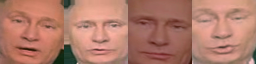

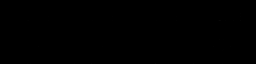

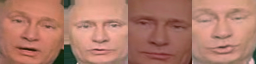

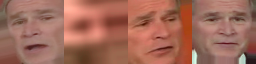

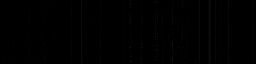

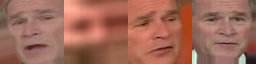

display result epoch: 50


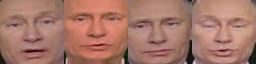

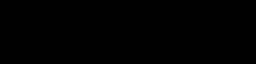

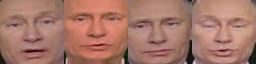

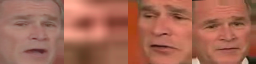

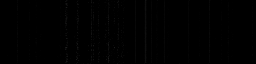

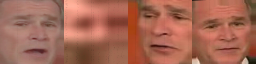

display result epoch: 100


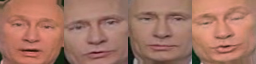

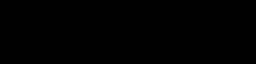

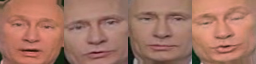

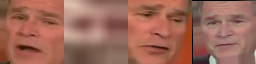

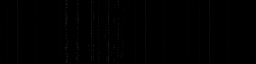

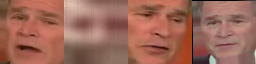

In [0]:
import network
import dataset
import os
from IPython.display import display
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
import torch
import vggface
from glob import glob
import imp
imp.reload(network)

config = {'isTrain': True,
          'loss_weight_config': {'reconstruction_loss': 1,
                                 'adversarial_loss_discriminator': 0.1,
                                 'adversarial_loss_generator': 0.1,
                                 'cycle_consistency_loss': 0.1,
                                 'perceptual_loss': [0.03, 0.1, 0.3, 0.1],
                                },

          'G_lr': 0.0001,
          'D_lr': 0.0002,
          'C_lr': 0.0001,
          'batchsize': 4,
          'resize': 256,
          'epochs': 1000,
          'cycleepochs': 800,
          'display_interval': 50,
          'save_dir': './weights/',
          'save_interval': 100,
          'augmentation':{'rotate_degree': 5,
                          'flip': True,
                          'motion_blur': 0.6,
                         },
          'imagepath':['./faceA/align/', './faceB/align/'],
          
         }

# set global tensor type, must match the model type
torch.set_default_tensor_type(torch.FloatTensor)

# for the debug thing
torch.autograd.set_detect_anomaly(True)

if __name__ == '__main__':
    
    #build model to calculate perceptual loss 
    if not os.path.isdir('./weights'):
        os.mkdir('./weights')

    trainsetAfilenames = glob(config['imagepath'][0] + '*.*')
    trainsetBfilenames = glob(config['imagepath'][1] + '*.*')

    filenames = trainsetAfilenames + trainsetBfilenames
          
    data = dataset.Dataset(config, filenames)
    dataloader = DataLoader(data, config['batchsize'], drop_last=True)
   
    vggface, vggface_ft_pl = vggface.resnet50("resnet50_ft_weight.pkl", num_classes=8631)  # Pretrained weights fc layer has 8631 outputs
          
    
    model = network.CycleGAN(vggface, vggface_ft_pl, config=config)

    model.initialize_weights()

    for epoch in range(config['epochs']):

        if epoch % config['save_interval'] == 0:
            model.save_networks(epoch)
                    
        if epoch > config['cycleepochs']:
            model.cycle_consistency_loss = True
                    
        for batchdata in dataloader:
          
            # need to model.float() every epoch, cuz pytorch reconstruct the grapy every epoch
            
            model.train()
            model.cuda()
            model.float()

            model.set_input(batchdata)
            # model.display_train_data(batchdata)
            model.optimize_parameter()
                    
            # del mannully
            del model.realA
            del model.realB
            del model.warpedA
            del model.warpedB
            del model.outputA
            del model.outputB
            del model.maskA
            del model.maskB
            del model.fakeA
            del model.fakeB
            del model.fakeApred
            del model.fakeBpred
            del model.realApred             
            del model.realBpred
            if model.cycle_consistency_loss:
                del model.cycleA
                del model.cycleB
                
        if epoch % config['display_interval'] == 0:
          
            batchdata = iter(dataloader).next()
            model.set_input(batchdata)
            model.display_forward()
            
            print(f'display result epoch: {epoch}')
            
            batchsize = config['batchsize']
            
            display(Image.fromarray((np.concatenate(tuple(model.realB.cpu().numpy()[x] for x in range(batchsize)), 
                                                    axis=2)[::-1,:,:].transpose(1,2,0)*255).astype('uint8')))
                               
            display(Image.fromarray(np.squeeze((np.concatenate(tuple(model.displayAmask.cpu().numpy()[x] for x in range(batchsize)), 
                                                               axis=2).transpose(1,2,0)*255).astype('uint8'))))
            
            display(Image.fromarray((np.concatenate(tuple(model.displayA.cpu().numpy()[x] for x in range(batchsize)), axis=2)[::-1,:,:].transpose(1,2,0)*255).astype('uint8')))
              
            display(Image.fromarray((np.concatenate(tuple(model.realA.cpu().numpy()[x] for x in range(batchsize)), axis=2)[::-1,:,:].transpose(1,2,0)*255).astype('uint8')))
          
            display(Image.fromarray(np.squeeze((np.concatenate(tuple(model.displayBmask.cpu().numpy()[x] for x in range(batchsize)), 
                                                    axis=2).transpose(1,2,0)*255).astype('uint8'))))
            
            display(Image.fromarray((np.concatenate(tuple(model.displayB.cpu().numpy()[x] for x in range(batchsize)), axis=2)[::-1,:,:].transpose(1,2,0)*255).astype('uint8')))

            del model.displayAoutput
            del model.displayBoutput
            del model.displayAmask
            del model.displayBmask
            del model.displayA
            del model.displayB
            if model.cycle_consistency_loss:
                del model.cycleA
                del model.cycleB
